# Augmentation of image samples

Purpose of the document: To provide a interface for batch processing of image augmentations across a sample extracted from all images in the input

Augmentations performed:

<ul>
    <li> Flips: Horizontal and vertical </li>
    <li> Rotation, with size preservation - 60, 120, 180, 240, 300 degrees</li>
    <li> Gaussian Noise (Salt) - p=0.01</li>
    <li> Gaussian Blur - sigma=1.5</li>
    <li> Inversion of channels - 0.4</li>
    <li> Addition of contrast - 1.25</li>
    <li> Multiply - 1.2</li>
    <li> Sharpen images - alpha = (0,0.25)</li>
    <li> Snow dust in air - p=0.029</li>
</ul>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-required-libraries-and-images" data-toc-modified-id="Import-required-libraries-and-images-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import required libraries and images</a></span><ul class="toc-item"><li><span><a href="#Get-a-list-of-paths-for-all-images" data-toc-modified-id="Get-a-list-of-paths-for-all-images-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Get a list of paths for all images</a></span></li><li><span><a href="#Place-the-list-of-images-into-a-dataframe" data-toc-modified-id="Place-the-list-of-images-into-a-dataframe-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Place the list of images into a dataframe</a></span></li><li><span><a href="#Create-output-directories-to-store-the-augmented-images" data-toc-modified-id="Create-output-directories-to-store-the-augmented-images-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Create output directories to store the augmented images</a></span></li></ul></li><li><span><a href="#Test-a-few-augmentations" data-toc-modified-id="Test-a-few-augmentations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Test a few augmentations</a></span></li><li><span><a href="#Define-augmentation-parameters" data-toc-modified-id="Define-augmentation-parameters-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Define augmentation parameters</a></span></li><li><span><a href="#Create-combinations-of-all-acceptable-augmentations" data-toc-modified-id="Create-combinations-of-all-acceptable-augmentations-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Create combinations of all acceptable augmentations</a></span></li><li><span><a href="#Create-a-dataframe-containing-all-possible-augmentations-for-each-image,-and-sample-it" data-toc-modified-id="Create-a-dataframe-containing-all-possible-augmentations-for-each-image,-and-sample-it-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Create a dataframe containing all possible augmentations for each image, and sample it</a></span></li><li><span><a href="#Run-Augmentations" data-toc-modified-id="Run-Augmentations-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Run Augmentations</a></span><ul class="toc-item"><li><span><a href="#Create-a-list-of-all-augmentations" data-toc-modified-id="Create-a-list-of-all-augmentations-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Create a list of all augmentations</a></span></li><li><span><a href="#Create-a-function-that-will-run-the-augmentations-for-each-image" data-toc-modified-id="Create-a-function-that-will-run-the-augmentations-for-each-image-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Create a function that will run the augmentations for each image</a></span></li><li><span><a href="#Run-the-function-using-an-apply-function" data-toc-modified-id="Run-the-function-using-an-apply-function-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Run the function using an apply function</a></span></li></ul></li></ul></div>

## Import required libraries and images

In [1]:
import os
import imutils
import cv2
import imgaug as ia
from imgaug import augmenters as iaa
import pandas as pd

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline


In [4]:
PATH_INPUT_TRAIN = r'/Users/shyamravikumar/Documents/Workspace/BAI - Project/Input Files/Small/3. Train Test split/train'

In [13]:
# Path to resized & cleaned input images
PATH_OUTPUT = r'/Users/shyamravikumar/Documents/Workspace/BAI - Project/Input Files/Small/4. Augmented images'

In [6]:
SEED = 120

### Get a list of paths for all images

In [7]:
def get_valid_images_in_path(path):
    """
    Return a list of valid images in a path
    
    Parameters
    ----------
        
        path: str
            Location where the images are stored
            
    Returns
    -------
        
        list of str: List of images obtained from the directory
        
    """
    from keras_preprocessing.image.utils import _iter_valid_files
    from keras_preprocessing.image.directory_iterator import DirectoryIterator
    
    list_files = list(
        _iter_valid_files(path,
                          DirectoryIterator.white_list_formats,
                          follow_links=False))
    list_files = list(map(lambda x: os.path.join(*x), list_files))
    return list_files

In [8]:
# Identify the list of available categories/classes
classes = []
for subdir in sorted(os.listdir(PATH_INPUT_TRAIN)):
    if os.path.isdir(os.path.join(PATH_INPUT_TRAIN, subdir)):
        classes.append(subdir)
classes

['defective_lav', 'defective_ldl', 'non_defective']

### Place the list of images into a dataframe

In [9]:
list_dataframes = []
for category in classes:
    path_category = os.path.join(PATH_INPUT_TRAIN, category)
    list_images = get_valid_images_in_path(path_category)
    list_dataframes.append(
        pd.DataFrame({
            'path': list_images,
            'class': np.repeat(category, len(list_images))
        })
    )

In [10]:
data_images = pd.concat(list_dataframes)
data_images['filename'] = data_images['path'].apply(os.path.basename)

In [11]:
data_images.sample(5)

,path,class,filename
84,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective,nondef_ldl_7.JPG
13,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective,nondef_lav_24.JPG
17,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective,nondef_lav_3.JPG
32,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective,nondef_lav_45.JPG
1,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective,nondef_lav_11.JPG


### Create output directories to store the augmented images

In [14]:
# Ensure that the required o/p directories (for each class) exist. If not, they will be created
for feature in classes:
    folder = os.path.join(PATH_OUTPUT, feature)
    if not os.path.exists(folder):
        os.mkdir(folder)

## Test a few augmentations

In [15]:
img_input = imutils.opencv2matplotlib(cv2.imread(data_images.path.iloc[10]))

In [16]:
height=12
width=16
plt.rcParams['figure.figsize'] = (width,height)

In [18]:
# plt.imshow(img_input)

Just uncomment any one of the below, and then run the next line to view the results!

In [21]:
# augmentor = iaa.Affine(rotate=60,mode="symmetric")
# augmentor = iaa.Fliplr(1)
# augmentor = iaa.Flipud(1)
# augmentor = iaa.Salt(0.01)
# augmentor = iaa.GaussianBlur(sigma=1)
# augmentor = iaa.Invert(1)
# augmentor = iaa.GammaContrast(1.25)
# augmentor = iaa.Multiply(1.2)
# augmentor = iaa.Sharpen(alpha=1,lightness=1) # Only sharpen
augmentor = iaa.Add(-30) #Adjust brightness
## augmentor = iaa.AddToHueAndSaturation((-100,100)) #Adjust Hue and Saturation. Not implemented currently
# augmentor = iaa.Sequential([iaa.Flipud(1),iaa.Fliplr(1)]) #Inversion done to make snowflakes more visible

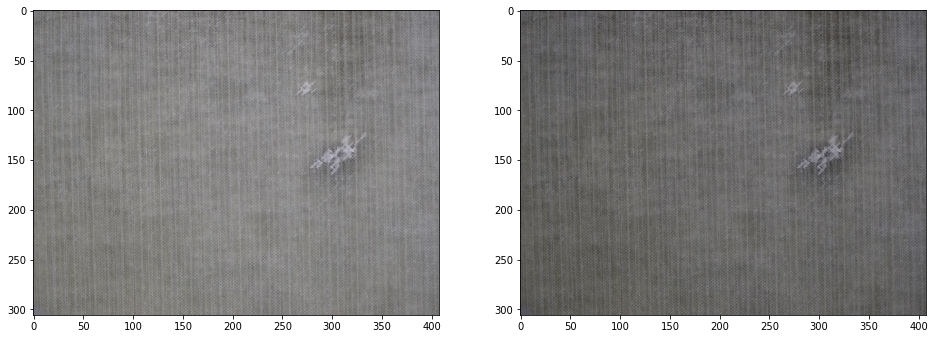

In [22]:
fig,(ax1,ax2) = plt.subplots(ncols=2)
ax1.imshow(img_input)
ax2.imshow(augmentor.augment_image(img_input))

## Define augmentation parameters

Create a dictionary of acceptable augmentations

In [41]:
acceptable_augmentations = {
    'flip_horizontal_on': iaa.Fliplr(1,name='flip_horizontal_on'),
    'flip_vertical_on': iaa.Flipud(1,name='flip_vertical_on'),
    'rotation_180': iaa.Affine(rotate=180,name='rotation_180'),
    'salt_p_0.01': iaa.Salt(0.01,name='salt_p_0.01'),
    'blur_gaussian_sigma_1': iaa.GaussianBlur(sigma=1,name='blur_gaussian_sigma_1'),
    'invert_on': iaa.Invert(1,name='invert_on'),
    'gamma_contrast_gamma_1.25': iaa.GammaContrast(1.25,name='gamma_contrast_gamma_1.25'),
    'multiply_mul_1.2': iaa.Multiply(1.2,name='multiply_mul_1.2'),
    'sharpen_on': iaa.Sharpen(alpha=1, lightness=1,name='sharpen_on'),
    'snowflakes_on': iaa.Snowflakes(0.029, speed=0.001, flake_size=(0.6, 0.8),name='snowflakes_on')
}
#Separate set of augmentations for brightness. One of these has to be used in every augmentation
# dict([('brightness_%s'%x,'iaa.Add(%s)'%x) for x in range(-60,61,10)])
#iaa.Add(0) is included so that images with original brightness are also included in the final list
acceptable_augmentations_brightness = {
    'brightness_off': iaa.Add(0,name='brightness_off'), 
    'brightness_-60': iaa.Add(-60,name='brightness_-60'),
    'brightness_-50': iaa.Add(-50,name='brightness_-50'),
    'brightness_-40': iaa.Add(-40,name='brightness_-40'),
    'brightness_-30': iaa.Add(-30,name='brightness_-30'),
    'brightness_-20': iaa.Add(-20,name='brightness_-20'),
    'brightness_-10': iaa.Add(-10,name='brightness_-10'),
    'brightness_10': iaa.Add(10,name='brightness_10'),
    'brightness_20': iaa.Add(20,name='brightness_20'),
    'brightness_30': iaa.Add(30,name='brightness_30'),
    'brightness_40': iaa.Add(40,name='brightness_40'),
    'brightness_50': iaa.Add(50,name='brightness_50'),
    'brightness_60': iaa.Add(60,name='brightness_60')
}

## Create combinations of all acceptable augmentations

Logic: 
<ol>
    <li>Extract all nC1,nC2,nC3,nC4,...nCn combinations from acceptable_augmentations</li>
    <li>Take all nC2 combinations from the combination of above results with acceptable brightnesses</li>
</ol>

In [42]:
from itertools import combinations, product

In [43]:
list_augmentations = acceptable_augmentations.keys()
list_brightnesses = [(x,) for x in acceptable_augmentations_brightness.keys()]

In [44]:
# Create combinations of all augmentations excluding brightness
combinations_augmentations_phase_1 = []
for i in range(1,len(list_augmentations)):
    combinations_augmentations_phase_1+= combinations(list_augmentations,i)

In [45]:
# Create combinations including brightness
combinations_augmentations_phase_2 = list(product(combinations_augmentations_phase_1,list_brightnesses))

In [46]:
print("There are %s possible combinations of augmentations for each image"%len(combinations_augmentations_phase_2))

There are 13286 possible combinations of augmentations for each image


In [47]:
from itertools import chain

Get a list of all possible augmentations

In [48]:
combinations_augmentations=list(map(lambda x:tuple(chain.from_iterable(x)),combinations_augmentations_phase_2))

In [49]:
combinations_augmentations[500:1000:100] # Print results

[('salt_p_0.01', 'sharpen_on', 'brightness_-10'),
 ('invert_on', 'multiply_mul_1.2', 'brightness_-50'),
 ('multiply_mul_1.2', 'snowflakes_on', 'brightness_50'),
 ('flip_horizontal_on', 'flip_vertical_on', 'sharpen_on', 'brightness_10'),
 ('flip_horizontal_on', 'rotation_180', 'snowflakes_on', 'brightness_-40')]

## Create a dataframe containing all possible augmentations for each image, and sample it

In [50]:
#Create a function for cross joining two datasets
def cartesian_product_simplified(left, right):
    la, lb = len(left), len(right)
    ia2, ib2 = np.broadcast_arrays(*np.ogrid[:la,:lb])

    return pd.DataFrame(
        np.column_stack([left.values[ia2.ravel()], right.values[ib2.ravel()]]))


In [51]:
res = cartesian_product_simplified(data_images,pd.DataFrame({'augmentations':combinations_augmentations}))

In [52]:
res.columns=list(data_images.columns)+['augmentations']

In [53]:
assert(res.shape[0] == data_images.shape[0] * len(combinations_augmentations))
res.shape

(1594320, 4)

In [55]:
res.sample(20)

,path,class,filename,augmentations
652876,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective,nondef_lav_27.JPG,"(salt_p_0.01, blur_gaussian_sigma_1, sharpen_o..."
753791,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective,nondef_lav_34.JPG,"(flip_horizontal_on, salt_p_0.01, blur_gaussia..."
740211,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective,nondef_lav_33.JPG,"(flip_horizontal_on, rotation_180, blur_gaussi..."
560401,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective,nondef_lav_19.JPG,"(flip_horizontal_on, flip_vertical_on, salt_p_..."
1543000,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective,nondef_ldl_3.JPG,"(salt_p_0.01, blur_gaussian_sigma_1, invert_on..."
537430,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective,nondef_lav_16.JPG,"(flip_horizontal_on, rotation_180, blur_gaussi..."
1186095,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective,nondef_lav_7.JPG,"(flip_vertical_on, salt_p_0.01, blur_gaussian_..."
296596,/Users/shyamravikumar/Documents/Workspace/BAI ...,defective_ldl,def_ldl_16.JPG,"(rotation_180, blur_gaussian_sigma_1, invert_o..."
367864,/Users/shyamravikumar/Documents/Workspace/BAI ...,defective_ldl,def_ldl_20.JPG,"(flip_horizontal_on, flip_vertical_on, invert_..."
399189,/Users/shyamravikumar/Documents/Workspace/BAI ...,defective_ldl,def_ldl_5.JPG,"(invert_on, multiply_mul_1.2, brightness_50)"


In [56]:
res.to_pickle(os.path.join(PATH_OUTPUT,"list_dataset_augmentations.pickle"))
# res=pd.read_pickle(os.path.join(PATH_OUTPUT,"list_dataset_augmentations.pickle"))

In [57]:
# If each image is 30 KB, what size would the resulting dataset have?
SIZE_IMAGE = 30
size_all_augmentations = SIZE_IMAGE*res.shape[0]/1024

In [58]:
size_all_augmentations, res.shape[0]

(46708.59375, 1594320)

In [59]:
# Create a sample size based on the expected size of the resulting dataset
EXPECTED_SIZE = 1000 #Size in MBs

frac_samples = EXPECTED_SIZE/size_all_augmentations
num_samples = int(res.shape[0] * frac_samples)


frac_samples, num_samples


(0.021409336477829628, 34133)

Create a stratified sampling based on class & filename

In [60]:
cols_for_stratified_sample = ['class','filename']
data_sampled = res.groupby(cols_for_stratified_sample,group_keys=False).apply(lambda x: x.sample(frac=frac_samples,random_state=SEED))

In [61]:
print(data_sampled.shape)
data_sampled.sample(10)

(34080, 4)


,path,class,filename,augmentations
1513005,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective,nondef_ldl_2.JPG,"(flip_horizontal_on, flip_vertical_on, blur_ga..."
1518573,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective,nondef_ldl_21.JPG,"(flip_vertical_on, invert_on, gamma_contrast_g..."
725012,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective,nondef_lav_32.JPG,"(rotation_180, salt_p_0.01, blur_gaussian_sigm..."
1105847,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective,nondef_lav_61.JPG,"(flip_horizontal_on, blur_gaussian_sigma_1, in..."
573426,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective,nondef_lav_20.JPG,"(blur_gaussian_sigma_1, multiply_mul_1.2, snow..."
828440,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective,nondef_lav_41.JPG,"(salt_p_0.01, invert_on, gamma_contrast_gamma_..."
1138858,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective,nondef_lav_65.JPG,"(flip_horizontal_on, rotation_180, blur_gaussi..."
840660,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective,nondef_lav_42.JPG,"(flip_vertical_on, salt_p_0.01, blur_gaussian_..."
1246660,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective,nondef_lav_73.JPG,"(flip_horizontal_on, flip_vertical_on, rotatio..."
395769,/Users/shyamravikumar/Documents/Workspace/BAI ...,defective_ldl,def_ldl_4.JPG,"(flip_vertical_on, salt_p_0.01, blur_gaussian_..."


Add a row number for each row in the dataframe, and a column to identify the augmentation

In [62]:
data_sampled.reset_index(inplace=True,drop=True)
data_sampled = data_sampled.reset_index().rename(columns={'index':'row_num'})
data_sampled['augmentation_identifier'] = 'aug_'+data_sampled['row_num'].astype('str')+'.jpg'

Add an output path for the augmented images

In [63]:
data_sampled['path_output'] = data_sampled.apply(lambda x: os.path.join(
    PATH_OUTPUT, x['class'], x['augmentation_identifier']),
                                                 axis=1)

## Run Augmentations

### Create a list of all augmentations

In [65]:
seq_aug = iaa.Sequential(list(
    acceptable_augmentations_brightness.values()) + list(
        acceptable_augmentations.values()))

len(seq_aug)

23

Sample code for reference

In [34]:

# images = np.random.randint(0, 255, (16, 128, 128, 3), dtype=np.uint8)
# seq = iaa.Sequential([iaa.Fliplr(0.5), iaa.GaussianBlur((0, 3.0))])

# # Show an image with 8*8 augmented versions of image 0 and 8*8 augmented
# # versions of image 1. Identical augmentations will be applied to
# # image 0 and 1.
# seq.show_grid([images[0], images[1]], cols=2, rows=2)

### Create a function that will run the augmentations for each image

Create a function to create hooks (i.e., only certain augmentations required by each sample will be run)

In [70]:
def read_image(path):
    # Read an image from a path, and return the results as an array
    # Currently, the color scheme is not changed from BGR to RGB using the following line, since we are not playing with hue anywhere
    # return imutils.opencv2matplotlib(cv2.imread(path))
    return cv2.imread(path)

def get_hook(names):
#     A helper function that will take in the list of augmentation names mentioned in the dataframe, and return a hook name for the same
    return lambda images,augmenter,parents,default: False if augmenter.name in names else default

def augment_and_save_image(row):
    aug_img = seq_aug.augment_image(read_image(row['path']),hooks=ia.HooksImages(get_hook(row['augmentations'])))
    
    # Store the save the augmented images
    cv2.imwrite(row['path_output'],aug_img)
    return aug_img

Test run the functions created

('rotation_180', 'invert_on', 'multiply_mul_1.2', 'brightness_-60')


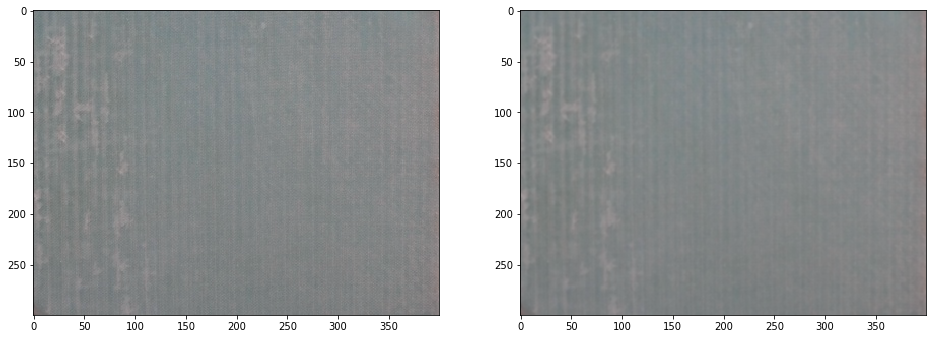

In [113]:
# row = data_sampled.sample(5,random_state=SEED).iloc[1]
# print(row['augmentations'])

# fig,(ax1,ax2) = plt.subplots(ncols=2)
# ax1.imshow(read_image(row['path']))
# ax2.imshow(augment_and_save_image(row))

# # plt.imshow(augment_and_save_image(row))

### Run the function using an apply function

In [67]:
# Export the sample data & augmentations applied, so it can be retrieved later when required
data_sampled.to_csv(os.path.join(PATH_OUTPUT,"list_augmentations_applied_lda.csv"),index=False)

In [68]:
# Can simply use the apply function. I'm using tqdm to monitor progress as well
from tqdm import tqdm
tqdm.pandas()

In [71]:
data_sampled.progress_apply(augment_and_save_image,axis=1)


  3%|▎         | 912/34080 [00:41<28:40, 19.28it/s]


  5%|▌         | 1851/34080 [01:20<22:24, 23.98it/s]


  8%|▊         | 2814/34080 [01:59<19:47, 26.32it/s]


 11%|█         | 3767/34080 [02:39<21:48, 23.17it/s]


 14%|█▎        | 4670/34080 [03:20<22:18, 21.97it/s]


 16%|█▋        | 5579/34080 [04:01<18:34, 25.56it/s]


 19%|█▉        | 6438/34080 [04:42<27:20, 16.85it/s]


 22%|██▏       | 7388/34080 [05:22<23:18, 19.08it/s]


 25%|██▍       | 8353/34080 [06:01<19:04, 22.48it/s]


 27%|██▋       | 9301/34080 [06:41<17:25, 23.70it/s]


 30%|██▉       | 10214/34080 [07:23<35:56, 11.07it/s]


 33%|███▎      | 11150/34080 [08:02<19:02, 20.07it/s]


 36%|███▌      | 12099/34080 [08:39<13:36, 26.93it/s]


 38%|███▊      | 12967/34080 [09:20<16:19, 21.55it/s]


 41%|████      | 13902/34080 [10:00<12:07, 27.74it/s]


 44%|████▎     | 14891/34080 [10:37<11:30, 27.79it/s]


 47%|████▋     | 15889/34080 [11:15<10:18, 29.40it/s]


 50%|████▉     | 16912/34080 [11:52<12:44, 22.46it/s]


 53%|█████▎    | 17907/34080 [12:31<10:37, 25.38it/s]


 55%|█████▌    | 18906/34080 [13:08<09:30, 26.58it/s]


 58%|█████▊    | 19922/34080 [13:45<09:28, 24.92it/s]


 61%|██████▏   | 20890/34080 [14:25<09:28, 23.21it/s]


 64%|██████▍   | 21898/34080 [15:02<07:21, 27.58it/s]


 67%|██████▋   | 22894/34080 [15:41<07:20, 25.41it/s]


 70%|██████▉   | 23849/34080 [16:19<08:58, 18.99it/s]


 73%|███████▎  | 24742/34080 [17:04<10:50, 14.36it/s]


 75%|███████▌  | 25621/34080 [17:45<05:23, 26.13it/s]


 78%|███████▊  | 26603/34080 [18:22<04:55, 25.28it/s]


 81%|████████  | 27540/34080 [19:02<04:29, 24.28it/s]


 84%|████████▎ | 28474/34080 [19:41<03:53, 24.05it/s]


 86%|████████▋ | 29437/34080 [20:19<03:00, 25.75it/s]


 89%|████████▉ | 30430/34080 [20:57<02:51, 21.32it/s]


 92%|█████████▏| 31394/34080 [21:35<01:38, 27.31it/s]


 95%|█████████▍| 32353/34080 [22:13<00:59, 29.20it/s]


 98%|█████████▊| 33323/34080 [22:51<00:32, 23.11it/s]


100%|██████████| 34080/34080 [23:26<00:00, 24.23it/s]

0        [[[183, 183, 183], [183, 183, 183], [183, 183,...
1        [[[29, 29, 29], [29, 29, 29], [29, 29, 29], [2...
2        [[[54, 54, 54], [54, 54, 54], [54, 54, 54], [5...
3        [[[200, 200, 200], [200, 200, 200], [200, 200,...
4        [[[180, 180, 180], [180, 180, 180], [180, 180,...
5        [[[78, 78, 78], [78, 78, 78], [78, 78, 78], [7...
6        [[[45, 45, 45], [45, 45, 45], [45, 45, 45], [4...
7        [[[54, 54, 54], [54, 54, 54], [54, 54, 54], [5...
8        [[[54, 54, 54], [54, 54, 54], [54, 54, 54], [5...
9        [[[200, 200, 200], [200, 200, 200], [200, 200,...
10       [[[95, 95, 95], [95, 95, 95], [95, 95, 95], [9...
11       [[[34, 34, 34], [34, 34, 34], [34, 34, 34], [3...
12       [[[240, 240, 240], [240, 240, 240], [240, 240,...
13       [[[170, 170, 170], [170, 170, 170], [170, 170,...
14       [[[252, 252, 252], [252, 252, 252], [252, 252,...
15       [[[240, 240, 240], [240, 240, 240], [240, 240,...
16       [[[45, 45, 45], [45, 45, 45], [45, 45, 45], [4.